In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import pandas.rpy.common as com
import numpy as np

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(plyr)

###These files are from the [binning notebook](./OTU_binning.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [4]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PE = prune_samples((physeq.md$Bulk == 0), physeq)
physeq.PE.snorm = transform_sample_counts(physeq.PE, function(x) x/sum(x))
#physeq.PE.thresh = filter_taxa(physeq.PE.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE.snorm)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10361 taxa and 395 samples ]
sample_data() Sample Data:       [ 395 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 10361 tips and 10360 internal nodes ]


In [5]:
%%R
mdf = psmelt(physeq.PE.snorm)

In [6]:
%%R
sample.data = sample_data(physeq.PE.snorm)
asNum = function(x) as.numeric(as.character(x))
sample.data$Density = asNum(sample.data$Density)
sample.data$Day = asNum(sample.data$Day)
sample.data$Treatment = as.character(sample.data$Treatment)
sample.data = sample.data[,c("Day","Treatment","Density")]
aggdata.min = aggregate(sample.data, by = list(sample.data$Treatment, sample.data$Day), FUN = min, na.rm = TRUE)
aggdata.max = aggregate(sample.data, by = list(sample.data$Treatment, sample.data$Day), FUN = max, na.rm = TRUE)
minmax = max(aggdata.min$Density)
maxmin = min(aggdata.max$Density)

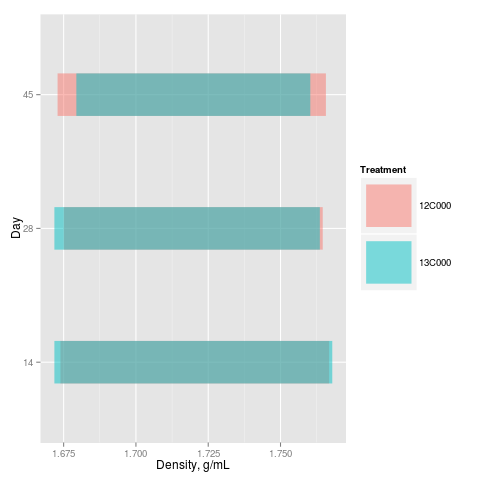

In [7]:
%%R
aggdata.minmax = ddply(sample.data, .(Day, Treatment), summarize, min = min(Density), max = max(Density))
#print(aggdata.minmax)
p = ggplot(aggdata.minmax) 
p = p + geom_segment(aes(y = factor(Day), yend = factor(Day), 
                         x = min, xend = max,
                         color = Treatment), size = I(20), alpha = 0.5,
                         data = subset(aggdata.minmax, Treatment %in% c("12C000", "13C000")))

p = p + ylab("Day") + xlab("Density, g/mL")

p

In [8]:
maxmin = %Rget maxmin
minmax = %Rget minmax
maxmin = maxmin[0]
minmax = minmax[0]
print maxmin, minmax

1.7603 1.6794


In [9]:
mdf = com.load_data("mdf")
mdf["Density"] = mdf["Density"].astype(float)
mdf.reset_index(inplace=True)

In [10]:
mdf.head()

,index,Sample,OTU,Abundance,sample_Sample,FractionNum,Bulk,Control,CC,X100,X700,H2O,Day,Density,rep,contolVlabel,Treatment
0,445604,12C.000.28.03.27,OTU.22,0.500000,12C.000.28.03.27,27,0,1,1,0,0,0,28,1.6794,,control,12C000
1,452170,12C.000.28.03.27,OTU.80,0.500000,12C.000.28.03.27,27,0,1,1,0,0,0,28,1.6794,,control,12C000
2,4083218,13C.700.45.03.21,OTU.8,0.500000,13C.700.45.03.21,21,0,0,0,0,1,0,45,1.6761,,label,13C700
3,4087704,13C.700.45.03.21,OTU.598,0.500000,13C.700.45.03.21,21,0,0,0,0,1,0,45,1.6761,,label,13C700
4,685593,12C.100.14.05.04,OTU.7,0.408588,12C.100.14.05.04,4,0,1,0,1,0,0,14,1.7679,,control,12C100


In [11]:
def wavg(group, r = (minmax, maxmin), N=20):
    day, = set(group.Day) #should only be one day in each group
    g_sorted = group.sort("Density", ascending=True)
    d = g_sorted["Density"]
    w = g_sorted["Abundance"]
    x = np.linspace(r[0],r[1],N)
    yinterp = np.interp(x, d, w)
    return (x*yinterp).sum()/yinterp.sum()

In [12]:
mdf_grouped = mdf.groupby(("Day","Treatment","OTU"))
OTU_wavg = mdf_grouped.apply(wavg)

In [13]:
OTU_wavg_df = OTU_wavg.reset_index()
OTU_wavg_df.rename(columns={0:"density_wavg"}, inplace=True)
OTU_wavg_df.head()

,Day,Treatment,OTU,density_wavg
0,14,12C000,OTU.1,1.724260
1,14,12C000,OTU.10,1.724782
2,14,12C000,OTU.100,1.727748
3,14,12C000,OTU.1000,1.723447
4,14,12C000,OTU.10000,1.725014


In [14]:
l = []
for t in ["13C000"]:
    df_t = OTU_wavg_df[(OTU_wavg_df["Treatment"]==t)|(OTU_wavg_df["Treatment"]=="12C000")]
    df_t_pivot = pd.pivot_table(df_t, 
                           values="density_wavg", 
                           rows="OTU", 
                           cols=["Day",
 "Treatment"])
    g = df_t_pivot.groupby(level=0, axis=1)
    for k in g.groups:
        d = g.get_group(k)
        try:
            d["shift"] = d[(k, t)] - d[(k, "12C000")]
        except KeyError:
            continue
        df = pd.DataFrame.from_dict(d["shift"].to_dict(), orient="index")
        df.rename(columns={0 : "shift"}, inplace=True)
        df["Day"] = [k for i in df.index]
        df["Treatment"] = [t for i in df.index]
        l.append(df)

df_shift = pd.concat(l)
df_shift = df_shift.reset_index()
df_shift.rename(columns={"index" : "OTU"}, inplace=True)
df_shift.head()


/opt/anaconda/lib/python2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the 'cols' keyword is deprecated, use 'columns' instead
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the 'rows' keyword is deprecated, use 'index' instead
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,OTU,shift,Day,Treatment
0,OTU.4676,0.024507,28,13C000
1,OTU.759,-0.018045,28,13C000
2,OTU.9994,NaN,28,13C000
3,OTU.758,-0.006205,28,13C000
4,OTU.9015,NaN,28,13C000


In [15]:
print(df_shift)

             OTU     shift  Day Treatment
0       OTU.4676  0.024507   28    13C000
1        OTU.759 -0.018045   28    13C000
2       OTU.9994       NaN   28    13C000
3        OTU.758 -0.006205   28    13C000
4       OTU.9015       NaN   28    13C000
5       OTU.9996       NaN   28    13C000
6       OTU.5680       NaN   28    13C000
7       OTU.9017 -0.005967   28    13C000
8       OTU.9444       NaN   28    13C000
9       OTU.5418       NaN   28    13C000
10      OTU.9013       NaN   28    13C000
11       OTU.757 -0.035233   28    13C000
12       OTU.756 -0.024385   28    13C000
13      OTU.5419       NaN   28    13C000
14       OTU.839 -0.026961   28    13C000
15      OTU.1969  0.004429   28    13C000
16     OTU.12668       NaN   28    13C000
17     OTU.12666       NaN   28    13C000
18      OTU.1965  0.000017   28    13C000
19     OTU.12664 -0.008875   28    13C000
20      OTU.1967  0.040462   28    13C000
21     OTU.12662       NaN   28    13C000
22      OTU.1961 -0.021027   28   

In [16]:
df_shift.to_csv("data/density_shifts_CC.csv", sep=",", index=False)

In [17]:
!head data/density_shifts_CC.csv

OTU,shift,Day,Treatment
OTU.4676,0.024507476022623376,28,13C000
OTU.759,-0.018044877359034928,28,13C000
OTU.9994,,28,13C000
OTU.758,-0.006204948875000893,28,13C000
OTU.9015,,28,13C000
OTU.9996,,28,13C000
OTU.5680,,28,13C000
OTU.9017,-0.005966571833261547,28,13C000
OTU.9444,,28,13C000


In [18]:
df_shiftR = com.convert_to_r_dataframe(df_shift, strings_as_factors=True)
%Rpush df_shiftR

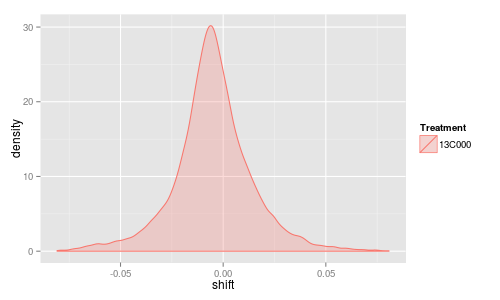

In [19]:
%%R -w 500 -h 300
p = ggplot(df_shiftR, aes(x = shift, color = Treatment, fill = Treatment))

p = p + geom_density(alpha = 0.25)

p